In [12]:
bench = 'tnb101_macro'
suffix = '_full' if bench != 'nb101' and 'macro' not in bench else '_first'
cfg = f'../zc_combine/configs/{bench}{suffix}.json'
dataset = 'cifar10' if 'tnb101' not in bench else 'class_scene'

In [13]:
from zc_combine.utils.script_utils import create_cache_filename
from zc_combine.utils.script_utils import load_feature_proxy_dataset

version_key = 'paper'
cache_path = create_cache_filename('../scripts/cache_data/', cfg, None, version_key, True)

_, data, y = load_feature_proxy_dataset('../data', bench, dataset, cfg=cfg, use_all_proxies=True,
                                        cache_path=cache_path, version_key=version_key)

In [14]:
from zc_combine.fixes.operations import get_ops_edges_nb201, get_ops_edges_tnb101, get_ops_nb101, get_ops_nb301


if bench == 'nb201':
    ops, _ = get_ops_edges_nb201()
elif bench == 'tnb101':    
    ops, _ = get_ops_edges_tnb101()
    ops = ops[:-1]  # no avg pooling
elif bench == 'nb101':
    ops = get_ops_nb101()
elif bench == 'nb301':
    ops = get_ops_nb301()
elif bench == 'tnb101_macro':
    ops = []
else:
    raise ValueError()

print("Loaded: ", ops)

better_op_names = {
    'input': 'input',
    'output': 'output',
    'none': 'zero',
    'skip_connect': 'skip',
    'nor_conv_1x1': 'conv1x1',
    'nor_conv_3x3': 'conv3x3',
    'sep_conv_3x3': 'sepconv3x3',
    'sep_conv_5x5': 'sepconv5x5',
    'dil_conv_3x3': 'dilconv3x3',
    'dil_conv_5x5': 'dilconv5x5',
    'maxpool3x3': 'maxpool3x3',
    'max_pool_3x3': 'maxpool3x3',
    'avg_pool_3x3': 'avgpool3x3',
    'conv1x1-bn-relu': 'conv1x1',
    'conv3x3-bn-relu': 'conv3x3'
}

ops = [better_op_names[o] for o in ops]
print("More readable: ", ops)

Loaded:  []
More readable:  []


In [15]:
if bench != 'nb301':
    op_map = {str(i): k for i, k in enumerate(ops)}
else:
    # out node is added
    op_map = {str(i + 1): k for i, k in enumerate(ops)}

if bench == 'nb101':
    del op_map['0']
    del op_map['1']  # no input/output node

In [16]:
c = 'min_path_len_banned_(0)'
if 'min_path' in c:
    opset = eval(c.split('_banned_')[1])
    if isinstance(opset, int):
        opset = (opset,)
    inverse_set = [i for i in op_map.keys() if i not in opset]
    print(inverse_set)

[]


In [19]:
def node_degree_bench(c, bench):
    if bench in ['tnb101', 'nb201', 'nb301']:
        if 'in_degree' in c:
            return 'Input node degree - '
        if "c_{k-2}" in c:
            return 'Input node 1 degree - '
        if "c_{k-1}" in c:
            return 'Input node 2 degree - '
        elif 'out_degree' in c:
            return 'Output node degree - '
        elif 'avg_in' in c:
            return 'Average outgoing degree - '
        elif 'avg_out' in c:
            return 'Average ingoing degree - '
        else:
            raise ValueError(f"Invalid node degree: {c}")
    if bench in ['nb101']:
        if 'in_degree' in c:
            return 'Output node degree - '
        elif 'out_degree' in c:
            return 'Input node degree - '
        else:
            c = c.split(')_')[1]
            assert c in ['avg_in', 'avg_out', 'max_in', 'max_out'], f"Invalid node degree: {c}"
            what, which = c.split('_')
            return f"{'Average' if what == 'avg' else 'Maximum'} {which}put node degree"


def get_feature_name(c):
    if 'op_count' in c:
        return 'number of '
    elif 'min_path' in c:
        return 'min path over '
    elif 'max_op' in c:
        return 'max path over '
    elif 'node_degree' in c:
        return node_degree_bench(c, bench)
    else:
        raise ValueError()

def to_better_colname(c, op_map):
    suffix = ''
    if 'normal' in c or 'reduce' in c:
        suffix = ' (normal)' if 'normal' in c else ' (reduce)'
        c = c.replace('_reduce', '').replace('_normal', '')
        
    if c.endswith('_c_{k-2}') or c.endswith('_c_{k-1}'):
        what = 'from input 1 ' if c == '_c_{k-2}' else 'from input 2 '
        c = c[:-8]
        suffix = f"{what}{suffix}"

    feature_name = get_feature_name(c)
    
    if 'min_path' in c:
        opset = eval(c.split('_banned_')[1])
        if isinstance(opset, int):
            opset = (opset,)
            
        opset = [str(o) for o in opset]
        opset = [i for i in op_map.keys() if i not in opset]
    elif 'op_count' in c:
        opset = c.split('_')[-1]
    else:
        opset = c.split('_allowed_')[1]
        if 'node' in c:
            opset = opset.split('_')[0]
        opset = eval(opset)
        
    if isinstance(opset, int):
        opset = [opset]

    opset = [op_map[str(o)] for o in opset] 
    opset = f"[{','.join(opset)}]" if len(opset) > 1 else str(opset[0])
        
    return f"{feature_name}{opset}{suffix}"


def to_better_colname_macro(c):
    if 'count_ops' in c:
        vals = c.replace('count_ops_ch', '')
        channels = vals.startswith('True')  # channel
        strides = vals.endswith('True')  # downsample
        
        if not channels and not strides:
            return "number of simple convs"
        
        what = []
        if channels:
            what.append('channel increased')
        if strides:
            what.append('strided')
        return f"number of convs - {' + '.join(what)}"
    elif 'pos' in c:
        vals = c.split('_')
        assert vals[2] in ['ch', 's']
        channels = vals[2] == 'ch'
        pos = vals[-1]
        what = 'channel increases' if channels else 'strides'
        return f"Number of {what} until pos. {pos}"
    else:
        raise ValueError()

In [20]:
new_cols_map = {}

for c in data.columns:   
    if bench == 'nb301' and c in ['op_count_normal_0', 'op_count_reduce_0']:
        # skip output node
        new_cols_map[c] = c
        continue
    
    if bench == 'nb101' and c in ['op_count_0', 'op_count_1']:
        # skip input/output nodes
        new_cols_map[c] = c
        continue
    
    if bench == 'tnb101' and c == 'op_count_4':
        # included max pooling that's however not there
        new_cols_map[c] = c
        continue
    try:
        if bench != 'tnb101_macro':
            new_c = to_better_colname(c, op_map)
        else:
            new_c = to_better_colname_macro(c)

        new_cols_map[c] = new_c
    except ValueError:
        print(f'Skipping {c}')
        new_cols_map[c] = c

Skipping fisher
Skipping flops
Skipping grad_norm
Skipping grasp
Skipping jacov
Skipping l2_norm
Skipping nwot
Skipping params
Skipping plain
Skipping snip
Skipping zen
Skipping epe_nas
Skipping synflow
Skipping net


In [21]:
new_cols_map

{'count_ops_chTruesTrue': 'number of convs - channel increased + strided',
 'count_ops_chTruesFalse': 'number of convs - channel increased',
 'count_ops_chFalsesTrue': 'number of convs - strided',
 'count_ops_chFalsesFalse': 'number of simple convs',
 'pos_state_ch_pos_0': 'Number of channel increases until pos. 0',
 'pos_state_s_pos_0': 'Number of strides until pos. 0',
 'pos_state_ch_pos_1': 'Number of channel increases until pos. 1',
 'pos_state_s_pos_1': 'Number of strides until pos. 1',
 'pos_state_ch_pos_2': 'Number of channel increases until pos. 2',
 'pos_state_s_pos_2': 'Number of strides until pos. 2',
 'pos_state_ch_pos_3': 'Number of channel increases until pos. 3',
 'pos_state_s_pos_3': 'Number of strides until pos. 3',
 'pos_state_ch_pos_4': 'Number of channel increases until pos. 4',
 'pos_state_s_pos_4': 'Number of strides until pos. 4',
 'pos_state_ch_pos_5': 'Number of channel increases until pos. 5',
 'pos_state_s_pos_5': 'Number of strides until pos. 5',
 'fisher': 

In [22]:
diffs = []

for k, v in new_cols_map.items():
    diffs.append(len(v) - len(k))

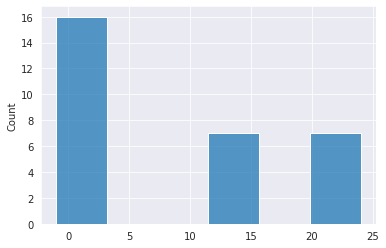

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(diffs)
plt.show()